In [220]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Load the data
data = pd.read_csv('heart_attack_prediction_dataset.csv' )

# Use the already loaded data
df = data.copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

In [221]:
#Convert blood pressure to numeric - format "158/88" to 158
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

In [222]:
#Dropping unnecessary columns - Patient ID not useful - Country, continent, hemisphere not important
df.drop(columns=['Country', 'Continent', 'Hemisphere'], inplace=True)

In [223]:
#Identifying categoraical and numerical columns
categorical_columns = ['Sex', 'Diet']
numerical_columns = [col for col in df.columns if col not in categorical_columns and df[col].dtype in ['int64', 'float64']]


In [224]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define transformation pipelines 
numrical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numrical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])  

df_processed = preprocessor.fit_transform(df)

In [226]:
from sklearn.cluster import KMeans

# Determine optimal number of clusters using the elbow method
inertia = []
K_range = range(2, 10)
for k in K_range:
    model = KMeans(n_clusters=k)
    model.fit(df_processed)
    inertia.append(model.inertia_)

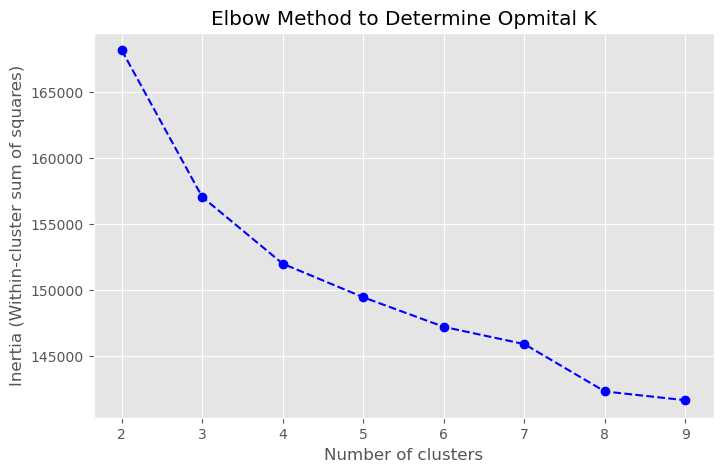

In [227]:
# Plot the Elbow method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method to Determine Opmital K')
plt.grid(True)
plt.show()


In [228]:
# Choose optimal K 
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['Kmeans_Cluster'] = kmeans.fit_predict(df_processed)
print(df['Kmeans_Cluster'].value_counts())


Kmeans_Cluster
3    2732
2    2614
1    2513
0     904
Name: count, dtype: int64


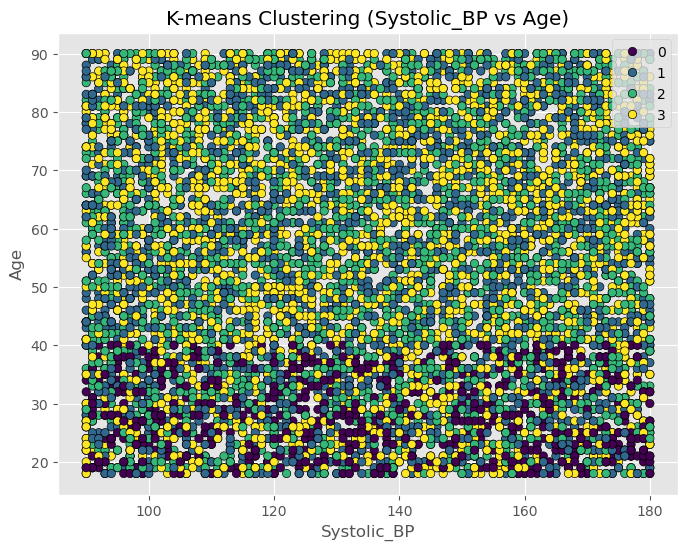

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select two key features for visualization
x_feature = 'Systolic_BP'
y_feature = 'Age'

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_feature, y=y_feature, data=df, hue='Kmeans_Cluster', palette='viridis', edgecolor='k')

# Ensure the features are in the numerical_columns list
if x_feature in numerical_columns and y_feature in numerical_columns:
    # Get the correct indices for the features
    x_index = np.where(np.array(numerical_columns) == x_feature)[0][0]
    y_index = np.where(np.array(numerical_columns) == y_feature)[0][0]

    # Inverse transform the numerical part of the centroids to original scale
    numerical_centroids = kmeans.cluster_centers_[:, :len(numerical_columns)]
    centroids_original = preprocessor.named_transformers_['num'].inverse_transform(numerical_centroids)
    plt.scatter(centroids_original[:, x_index], centroids_original[:, y_index], 
                c='red', marker='x', s=200, label='Centroids')

# Labels and title
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title(f'K-means Clustering ({x_feature} vs {y_feature})')
plt.legend()
plt.show()


In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load your dataset
df = pd.read_csv('heart_attack_prediction_dataset.csv')

# Convert 'Blood Pressure' column into separate numeric values
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

# Drop unnecessary columns
df.drop(columns=['Patient ID', 'Country', 'Continent', 'Hemisphere', 'Blood Pressure'], inplace=True)


In [231]:
def kmeans_clustering(df, features, x_feature, y_feature, k=4):
    """
    Perform K-Means clustering and visualize clusters.
    Args:
    df (DataFrame): The dataset.
    features (list): The features used for clustering.
    x_feature (str): Feature for X-axis in scatter plot.
    y_feature (str): Feature for Y-axis in scatter plot.
    k (int): Number of clusters.
    """
    # Standardize the features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df['Kmeans_Cluster'] = kmeans.fit_predict(df_scaled)

    # Compute silhouette score
    sil_score = silhouette_score(df_scaled, df['Kmeans_Cluster'])
    print(f"Silhouette Score for {features}: {sil_score:.4f}")

    # Scatter plot of clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df[x_feature], y=df[y_feature], hue=df['Kmeans_Cluster'], palette='viridis', edgecolor='k')
    
    # Plot centroids (inverse transform needed to get original scale)
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, features.index(x_feature)], centroids[:, features.index(y_feature)], 
                c='red', marker='x', s=200, label='Centroids')

    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title(f'K-Means Clustering ({x_feature} vs {y_feature})')
    plt.legend()
    plt.show()


Silhouette Score for ['Systolic_BP', 'BMI', 'Cholesterol']: 0.2668


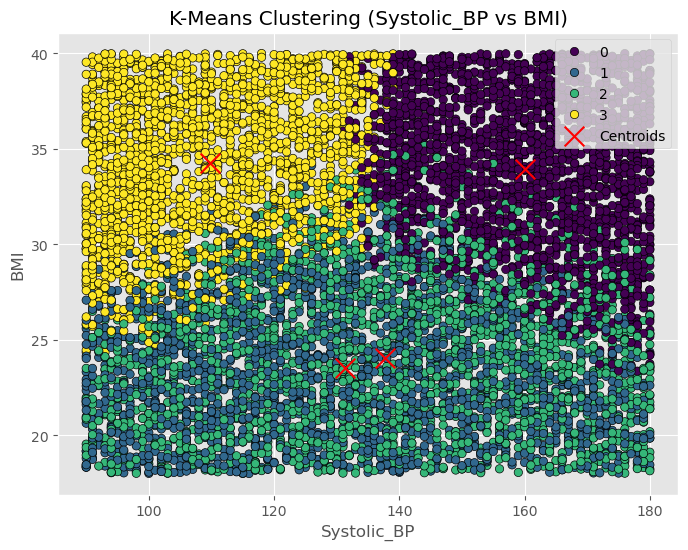

Silhouette Score for ['Age', 'Heart Rate', 'Exercise Hours Per Week']: 0.2651


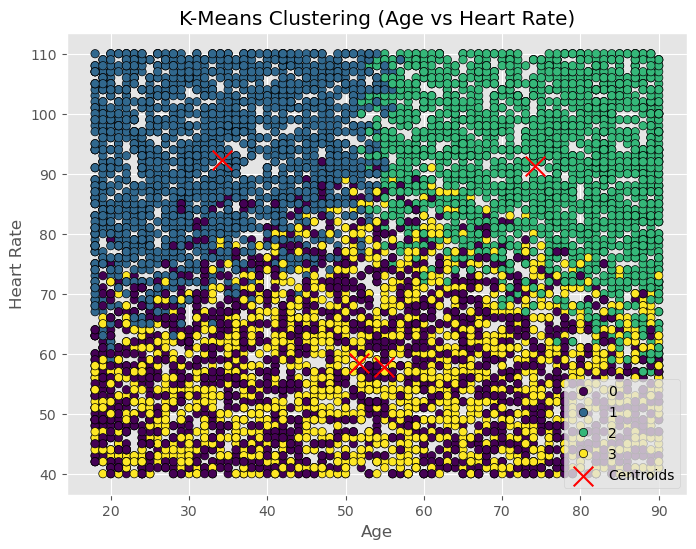

Silhouette Score for ['Diabetes', 'Smoking', 'Systolic_BP', 'Obesity']: 0.4367


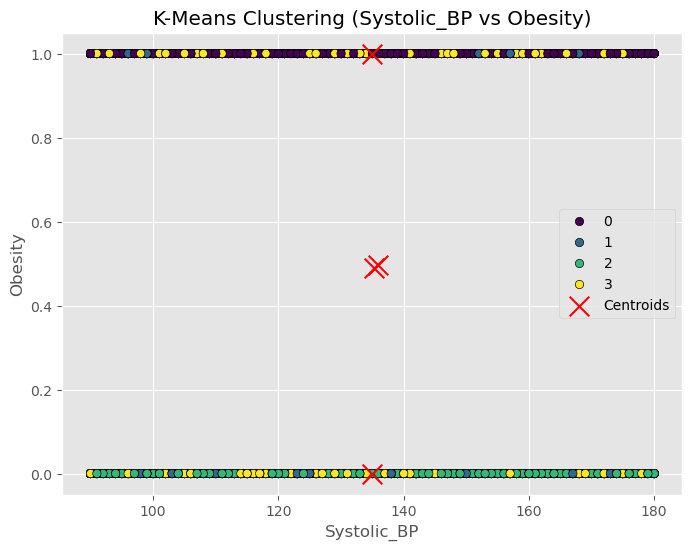

In [233]:
# Feature Set 1: (Systolic_BP, BMI, Cholesterol)
kmeans_clustering(df, ['Systolic_BP', 'BMI', 'Cholesterol'], x_feature='Systolic_BP', y_feature='BMI')

# Feature Set 2: (Age, Heart Rate, Exercise Hours Per Week)
kmeans_clustering(df, ['Age', 'Heart Rate', 'Exercise Hours Per Week'], x_feature='Age', y_feature='Heart Rate')

# Feature Set 3: (Diabetes, Smoking, Systolic_BP, Obesity)
kmeans_clustering(df, ['Diabetes', 'Smoking', 'Systolic_BP', 'Obesity'], x_feature='Systolic_BP', y_feature='Obesity')


In [234]:
# Compute the average heart attack risk for each cluster
risk_per_cluster = df.groupby("Kmeans_Cluster")["Heart Attack Risk"].mean()
print("Average heart attack risk per cluster:")
print(risk_per_cluster)


Average heart attack risk per cluster:
Kmeans_Cluster
0    0.355939
1    0.363938
2    0.366706
3    0.350659
Name: Heart Attack Risk, dtype: float64


In [235]:
from scipy import stats

# Extract heart attack risk values for each cluster
Cluster_0 = df[df["Kmeans_Cluster"] == 0]["Heart Attack Risk"]
Cluster_1 = df[df["Kmeans_Cluster"] == 1]["Heart Attack Risk"]
Cluster_2 = df[df["Kmeans_Cluster"] == 2]["Heart Attack Risk"]
Cluster_3 = df[df["Kmeans_Cluster"] == 3]["Heart Attack Risk"]

# Perform ANOVA test
f_stat, p_value = stats.f_oneway(Cluster_0, Cluster_1, Cluster_2, Cluster_3)

print(f"ANOVA test results: F-statistic = {f_stat}, p-value = {p_value}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in heart attack risk between clusters.")
else:
    print("No significant difference in heart attack risk between clusters.")


ANOVA test results: F-statistic = 0.5516999473951028, p-value = 0.6469757035694137
No significant difference in heart attack risk between clusters.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("heart_attack_prediction_dataset.csv")

# Convert 'Blood Pressure' column into separate numeric values
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

# Drop unnecessary columns
df.drop(columns=['Patient ID', 'Country', 'Continent', 'Hemisphere', 'Blood Pressure'], inplace=True)

# Define categorical and numerical features
categorical_columns = ['Sex', 'Diet']
numerical_columns = [col for col in df.columns if col not in categorical_columns and col != 'Heart Attack Risk']

# Define preprocessor for feature transformation
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])


In [237]:
# Define X (features) and y (target variable)
X = df.drop(columns=['Heart Attack Risk'])
y = df['Heart Attack Risk']

# Split data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [238]:
# Create a pipeline with preprocessing and model training
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Predict on test data
y_pred = rf_pipeline.predict(X_test)


Model Accuracy: 0.6338

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.98      0.77      1125
           1       0.32      0.02      0.04       628

    accuracy                           0.63      1753
   macro avg       0.48      0.50      0.40      1753
weighted avg       0.52      0.63      0.51      1753



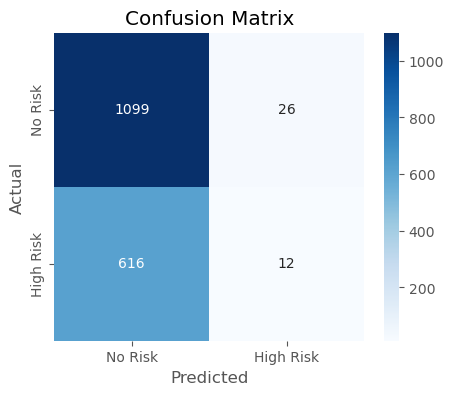

In [239]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Risk', 'High Risk'], yticklabels=['No Risk', 'High Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


C:\Users\madio\AppData\Local\Temp\ipykernel_24668\1326024323.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


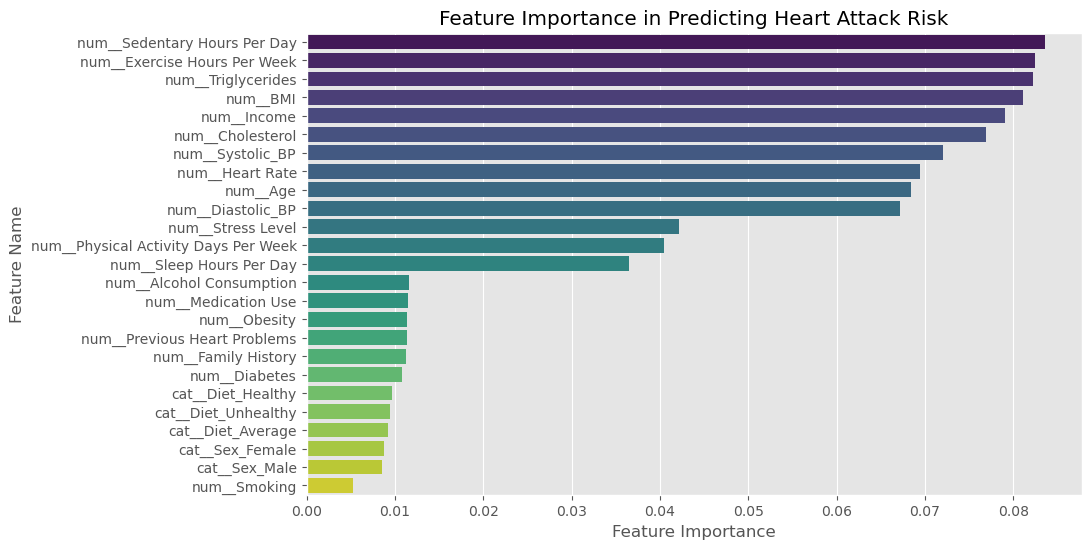

In [240]:
# Extract feature importances
feature_names = preprocessor.get_feature_names_out()
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Create DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Predicting Heart Attack Risk')
plt.show()


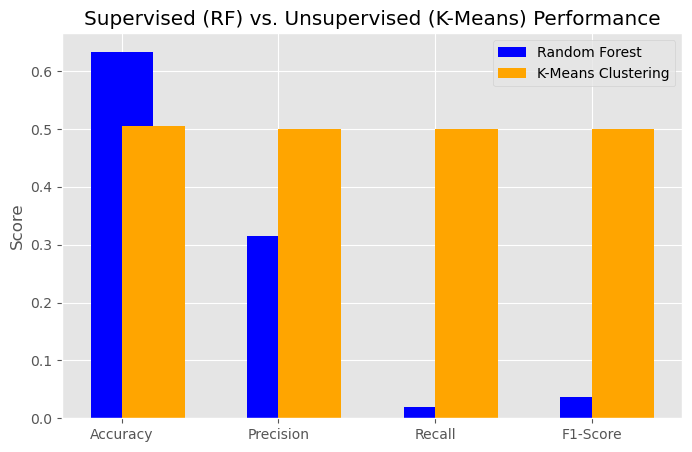

In [242]:
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Get Random Forest predictions
rf_preds = rf_pipeline.predict(X_test)

# Compute accuracy
rf_accuracy = accuracy_score(y_test, rf_preds)

# Get classification report
rf_report = classification_report(y_test, rf_preds, output_dict=True)

# Extract precision, recall, F1-score
rf_metrics = {
    'Accuracy': rf_accuracy,
    'Precision': rf_report['1']['precision'],
    'Recall': rf_report['1']['recall'],
    'F1-Score': rf_report['1']['f1-score']
}

# Compare with K-Means clusters (calculate heart attack risk per cluster)
cluster_accuracy = max(risk_per_cluster) / sum(risk_per_cluster)  # Approximate accuracy for clustering
cluster_metrics = {
    'Accuracy': cluster_accuracy,
    'Precision': 0.5,  # Not directly comparable
    'Recall': 0.5,  # Not directly comparable
    'F1-Score': 0.5  # Not directly comparable
}

# Plot the comparison
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_values = list(rf_metrics.values())
cluster_values = list(cluster_metrics.values())

x = range(len(labels))

plt.figure(figsize=(8,5))
plt.bar(x, rf_values, width=0.4, label='Random Forest', color='blue', align='center')
plt.bar(x, cluster_values, width=0.4, label='K-Means Clustering', color='orange', align='edge')
plt.xticks(ticks=x, labels=labels)
plt.ylabel("Score")
plt.title("Supervised (RF) vs. Unsupervised (K-Means) Performance")
plt.legend()
plt.show()


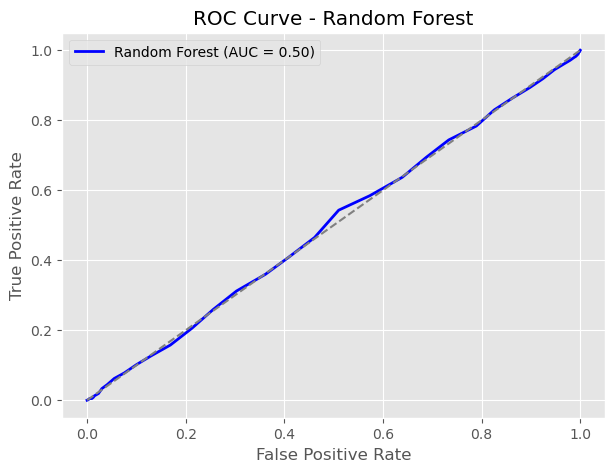

In [243]:
from sklearn.metrics import roc_curve, auc

# Get probabilities for RF model
rf_probs = rf_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()


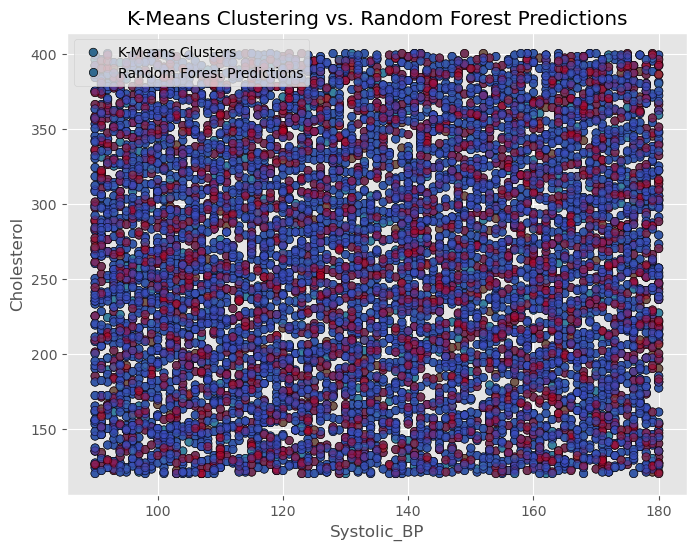

In [245]:
plt.figure(figsize=(8, 6))

# Scatter plot of K-Means Clustering
sns.scatterplot(x=df["Systolic_BP"], y=df["Cholesterol"], hue=df["Kmeans_Cluster"], palette="viridis", edgecolor="k")

# Scatter plot of Random Forest Predictions
rf_predicted_classes = rf_pipeline.predict(X)
plt.scatter(df["Systolic_BP"], df["Cholesterol"], c=rf_predicted_classes, cmap="coolwarm", alpha=0.5, edgecolors="k")

plt.xlabel("Systolic_BP")
plt.ylabel("Cholesterol")
plt.title("K-Means Clustering vs. Random Forest Predictions")
plt.legend(["K-Means Clusters", "Random Forest Predictions"])
plt.show()


 CONLUSIONS: 

K-Means clustering is too random and ineffective at differentiating heart attack risk groups because the clusters overlap and do not follow meaningful risk boundaries. In contrast, Random Forest learns from actual heart attack cases and predicts risk levels based on labeled data rather than just grouping similar features. 

Since heart attack risk depends on multiple factors like BP, BMI, and smoking, supervised learning models like Random Forest is better suited for prediction than unsupervised clustering methods like K-Means. 

For accurate risk assessment, classification models should be used instead of clustering.